# Blogs recommendation model using w2v skipgram model

Reviewing the blogs analysis using tfidf metrics, we have some good results on the blogs embedding; however we can't use tfidf because it does not scale, the reason is that the shape of the matrix is dinamic and it's scale up depending on the quantity of unique words and blogs. That's not good because working with the tfidf matrix is not optimize. What we want is a fixed embedding dimension, and the only dinamic axis will be the blogs, so that our matrix just scale up along the blogs axis (the rows).

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

from tqdm import tqdm
from bs4 import BeautifulSoup
from utils import *

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

tqdm.pandas(desc="Preprocess dataset")
%matplotlib inline

In [3]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

# Load dataset

In [4]:
blogs_df = pd.read_csv("data/blogs_data.csv")

In [5]:
blogs_df.head() # This data is already preprocess and normalize in English

,id,title,content,slug,data,lang,normalize_data
0,5173,Why Scalability Matters for Your App,Building an app is an extensive process. From ...,why-scalability-matters-for-your-app,Why Scalability Matters for Your App Building ...,en,Why Scalability Matters for Your App Building ...
1,5174,Is a Scrum Agile Development Process Right for...,A Brief History of Scrum Agile Development: \n...,is-a-scrum-agile-development-process-right-for...,Is a Scrum Agile Development Process Right for...,en,Is a Scrum Agile Development Process Right for...
2,5175,How to Make Your App Irresistible Through User...,Guessing is a part of life—and it’s necessary....,how-to-make-your-app-irresistible-through-user...,How to Make Your App Irresistible Through User...,en,How to Make Your App Irresistible Through User...
3,5176,5 Product Manager MUSTS for Creating a Success...,Product management is a tough job. You must tr...,5-product-manager-musts-for-creating-a-success...,5 Product Manager MUSTS for Creating a Success...,en,5 Product Manager MUSTS for Creating a Success...
4,5177,7 Key Questions to Ask Your Prospective App De...,From the moment you decide to move forward wit...,7-key-questions-to-ask-prospective-app-develop...,7 Key Questions to Ask Your Prospective App De...,en,7 Key Questions to Ask Your Prospective App De...


In [6]:
print(blogs_df["normalize_data"][0])

Why Scalability Matters for Your App Building an app is an extensive process. From a fresh idea to a marketable product, the journey is filled with ups and downs. So, when you (hopefully) build that successful app, the last thing you want is for it to hit a dead end.
However, that’s, unfortunately, the way it usually goes. You might think that accelerated growth is totally positive, as users are downloading your app at a record rate. But, an app that isn’t designed and developed to seamlessly handle this explosive growth will eventually end up being a failure.
Consider this: is your app, as it stands today, able to scale up to exponential growth? If you have any doubts, you need to seriously consider this scalability issue.

What is app scalability?
Scalability is the ability of your app to handle a growing number of customers, clients and/or users. It also pertains to the ability of your current or future developer to maintain the app. Consider the possibility that your app isn’t curr

# Preprocess data for training

In [7]:
regex = get_regex_expression()
regex

'(https?:\\/\\/.*[\\r\\n])|(\\#[^\\s]*)|(\\@[^\\s]*)|(author)|(\\S*@\\S+)|([^a-zA-Z0-9À-ÿ\\u00f1\\u00d1\\s])'

In [8]:
example = preprocess_data(blogs_df["normalize_data"][0], regex, 
                          removing_stops=True, lemmatize=True)
print(example)

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

In [29]:
# Train data doing lemmatization and removing stopswords
train_data = [preprocess_data(normalize_data, regex, True, True) 
                for normalize_data in tqdm(blogs_df["normalize_data"].values)]

100%|██████████| 458/458 [00:52<00:00,  8.71it/s]


In [30]:
print(train_data[0])

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

# Get Bigrams

In [31]:
from gensim.models import Phrases

In [32]:
bigrams = Phrases(train_data, min_count=1, threshold=5)

2020-06-08 20:11:38,694 : INFO : collecting all words and their counts
2020-06-08 20:11:38,695 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-06-08 20:11:38,992 : INFO : collected 159713 word types from a corpus of 224885 words (unigram + bigrams) and 458 sentences
2020-06-08 20:11:38,993 : INFO : using 159713 counts as vocab in Phrases<0 vocab, min_count=1, threshold=5, max_vocab_size=40000000>


In [34]:
print(bigrams[train_data[0]])

['scalability', 'matter', 'app', 'build', 'app', 'extensive_process', 'fresh', 'idea', 'marketable_product', 'journey', 'fill', 'up_down', 'hopefully_build', 'successful_app', 'thing', 'want_hit', 'dead_end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle_explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able_scale', 'exponential_growth', 'doubt', 'need_seriously', 'consider_scalability', 'issue', 'app', 'scalability_scalability', 'ability', 'app', 'handle_grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional_feature', 'flexible', 'coding', 'keep', 'app', 'run_smoothly', 'benefit', 'scalable', 'app', 'need',

# Create a model with gensim

## Gensim api Important hyperparameters
```
sentences : iterable of iterables, optional
            The `sentences` iterable can be simply a list of lists of tokens.
            
size : int, optional
    Dimensionality of the word vectors.
    
window : int, optional
    Maximum distance between the current and predicted word within a sentence.
    
min_count : int, optional
    Ignores all words with total frequency lower than this.
    
workers : int, optional
    Use these many worker threads to train the model (=faster training with multicore machines).
    
sg : {0, 1}, optional
    Training algorithm: 1 for skip-gram; otherwise CBOW.
    
hs : {0, 1}, optional
    If 1, hierarchical softmax will be used for model training.
    If 0, and `negative` is non-zero, negative sampling will be used.
    
negative : int, optional
    If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
    should be drawn (usually between 5-20).
    If set to 0, no negative sampling is used.
    
ns_exponent : float, optional
        The exponent used to shape the negative sampling distribution. A value of 1.0 samples exactly in               proportion to the frequencies, 0.0 samples all words equally, while a negative value samples 
        low-frequency words more than high-frequency words. The popular default value of 0.75 was chosen by
        the original Word2Vec paper.
        
cbow_mean : {0, 1}, optional
    If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
    
alpha : float, optional
    The initial learning rate.
    
min_alpha : float, optional
    Learning rate will linearly drop to `min_alpha` as training progresses.
    
max_vocab_size : int, optional
    Limits the RAM during vocabulary building; if there are more unique
    words than this, then prune the infrequent ones. Every 10 million word types need about 1GB of RAM.
    Set to `None` for no limit.
    
max_final_vocab : int, optional
    Limits the vocab to a target vocab size by automatically picking a matching min_count. If the specified
    min_count is more than the calculated min_count, the specified min_count will be used.
    Set to `None` if not required.
    
sample : float, optional
    The threshold for configuring which higher-frequency words are randomly downsampled,
    useful range is (0, 1e-5).
    
iter : int, optional
    Number of iterations (epochs) over the corpus.
    
trim_rule : function, optional
    Vocabulary trimming rule, specifies whether certain words should remain in the vocabulary,
    be trimmed away, or handled using the default (discard if word count < min_count).
    Can be None (min_count will be used, look to :func:`~gensim.utils.keep_vocab_item`),
    or a callable that accepts parameters (word, count, min_count) and returns either
    :attr:`gensim.utils.RULE_DISCARD`, :attr:`gensim.utils.RULE_KEEP` or :attr:`gensim.utils.RULE_DEFAULT`.
    The rule, if given, is only used to prune vocabulary during build_vocab() and is not stored as part of the
    model.

    The input parameters are of the following types:
        * `word` (str) - the word we are examining
        * `count` (int) - the word's frequency count in the corpus
        * `min_count` (int) - the minimum count threshold.
        
sorted_vocab : {0, 1}, optional
    If 1, sort the vocabulary by descending frequency before assigning word indexes.
    See :meth:`~gensim.models.word2vec.Word2VecVocab.sort_vocab()`.
    
batch_words : int, optional
    Target size (in words) for batches of examples passed to worker threads (and
    thus cython routines).(Larger batches will be passed if individual
    texts are longer than 10000 words, but the standard cython code truncates to that maximum.)
```
To see the best choose of hyperparameter this paper:

https://arxiv.org/pdf/1804.04212.pdf

In [36]:
from gensim.models import Word2Vec
import multiprocessing
number_cpus = multiprocessing.cpu_count()

## Define hyperparameters

In [37]:
parameters = {"min_count":0, "size":300, "sg":1, "window":5, "iter":110,
                   "sample": 1e-4, "hs": 0, "negative": 15, "ns_exponent": -0.5,
                   "workers": number_cpus}

In [38]:
sg_model = Word2Vec(**parameters)

In [39]:
train_data = [text_vector for text_vector in tqdm(bigrams[train_data])]

100%|██████████| 458/458 [00:00<00:00, 841.25it/s]


## Build vocab

In [41]:
# Build vocab
sg_model.build_vocab(train_data, progress_per=100000)

2020-06-08 20:12:18,717 : INFO : collecting all words and their counts
2020-06-08 20:12:18,717 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-08 20:12:18,752 : INFO : collected 21009 word types from a corpus of 183555 raw words and 458 sentences
2020-06-08 20:12:18,753 : INFO : Loading a fresh vocabulary
2020-06-08 20:12:18,791 : INFO : effective_min_count=0 retains 21009 unique words (100% of original 21009, drops 0)
2020-06-08 20:12:18,792 : INFO : effective_min_count=0 leaves 183555 word corpus (100% of original 183555, drops 0)
2020-06-08 20:12:18,850 : INFO : deleting the raw counts dictionary of 21009 items
2020-06-08 20:12:18,851 : INFO : sample=0.0001 downsamples 597 most-common words
2020-06-08 20:12:18,851 : INFO : downsampling leaves estimated 126997 word corpus (69.2% of prior 183555)
2020-06-08 20:12:18,896 : INFO : estimated required memory for 21009 words and 300 dimensions: 60926100 bytes
2020-06-08 20:12:18,897 : INFO : resetting lay

## Load pretrained vectors

Run to compare with differen pretrained vectors

In [42]:
# sg_model.intersect_word2vec_format("model/word2vec-google-news-300.gz", binary=True)

## Train skip-gram model

In [43]:
sg_model.train(train_data, total_examples=sg_model.corpus_count, 
                  epochs=sg_model.epochs)

2020-06-08 20:12:30,926 : INFO : training model with 8 workers on 21009 vocabulary and 300 features, using sg=1 hs=0 sample=0.0001 negative=15 window=5
2020-06-08 20:12:31,960 : INFO : EPOCH 1 - PROGRESS: at 51.31% examples, 65188 words/s, in_qsize 9, out_qsize 0
2020-06-08 20:12:32,008 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:12:32,017 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:12:32,052 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:12:32,092 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:12:32,094 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:12:32,262 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:12:32,312 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:12:32,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-

2020-06-08 20:12:42,961 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:12:42,967 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:12:42,979 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:12:43,130 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:12:43,184 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:12:43,194 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:12:43,194 : INFO : EPOCH - 9 : training on 183555 raw words (126933 effective words) took 1.4s, 93869 effective words/s
2020-06-08 20:12:44,202 : INFO : EPOCH 10 - PROGRESS: at 47.38% examples, 60167 words/s, in_qsize 8, out_qsize 2
2020-06-08 20:12:44,207 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:12:44,234 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:12:44,276 :

2020-06-08 20:12:53,984 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:12:53,985 : INFO : EPOCH - 17 : training on 183555 raw words (126909 effective words) took 1.4s, 93819 effective words/s
2020-06-08 20:12:54,999 : INFO : EPOCH 18 - PROGRESS: at 58.30% examples, 73185 words/s, in_qsize 8, out_qsize 0
2020-06-08 20:12:55,019 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:12:55,046 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:12:55,060 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:12:55,147 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:12:55,152 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:12:55,272 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:12:55,309 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:12:55,323 

2020-06-08 20:13:06,019 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:06,049 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:06,102 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:06,119 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:06,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:06,301 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:06,308 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:06,309 : INFO : EPOCH - 26 : training on 183555 raw words (126977 effective words) took 1.3s, 96098 effective words/s
2020-06-08 20:13:07,332 : INFO : EPOCH 27 - PROGRESS: at 51.31% examples, 65701 words/s, in_qsize 9, out_qsize 0
2020-06-08 20:13:07,367 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:07,378 

2020-06-08 20:13:16,954 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:16,956 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:16,956 : INFO : EPOCH - 34 : training on 183555 raw words (127226 effective words) took 1.3s, 100482 effective words/s
2020-06-08 20:13:17,945 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:17,967 : INFO : EPOCH 35 - PROGRESS: at 68.12% examples, 87215 words/s, in_qsize 6, out_qsize 1
2020-06-08 20:13:17,971 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:17,979 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:17,986 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:17,996 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:18,170 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:18,190

2020-06-08 20:13:27,693 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:27,709 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:27,734 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:27,735 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:27,883 : INFO : EPOCH 43 - PROGRESS: at 88.86% examples, 100494 words/s, in_qsize 2, out_qsize 1
2020-06-08 20:13:27,884 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:27,917 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:27,925 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:27,926 : INFO : EPOCH - 43 : training on 183555 raw words (127096 effective words) took 1.2s, 108648 effective words/s
2020-06-08 20:13:28,866 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:28,89

2020-06-08 20:13:37,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:37,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:37,070 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:37,071 : INFO : EPOCH - 51 : training on 183555 raw words (127065 effective words) took 1.1s, 112940 effective words/s
2020-06-08 20:13:37,918 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:37,931 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:37,970 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:37,992 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:38,011 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:38,123 : INFO : EPOCH 52 - PROGRESS: at 88.86% examples, 107900 words/s, in_qsize 2, out_qsize 1
2020-06-08 20:13:38,12

2020-06-08 20:13:46,707 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:46,726 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:46,733 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:46,737 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:46,758 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:46,899 : INFO : EPOCH 60 - PROGRESS: at 88.86% examples, 109431 words/s, in_qsize 2, out_qsize 1
2020-06-08 20:13:46,900 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:46,929 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:46,947 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:46,947 : INFO : EPOCH - 60 : training on 183555 raw words (127005 effective words) took 1.1s, 117255 effective words/s
2020-06-08 20:13:47,86

2020-06-08 20:13:56,512 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:56,568 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:13:56,582 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:13:56,610 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:13:56,641 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:13:56,642 : INFO : EPOCH - 68 : training on 183555 raw words (127040 effective words) took 1.1s, 111416 effective words/s
2020-06-08 20:13:57,575 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:13:57,576 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:13:57,638 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:13:57,642 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:13:57,648 : INFO : EPOCH 69 - P

2020-06-08 20:14:05,085 : INFO : EPOCH - 76 : training on 183555 raw words (126835 effective words) took 1.0s, 123530 effective words/s
2020-06-08 20:14:05,899 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:14:05,958 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:14:05,976 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:14:05,985 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:14:06,001 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:14:06,088 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:14:06,112 : INFO : EPOCH 77 - PROGRESS: at 94.32% examples, 117782 words/s, in_qsize 1, out_qsize 1
2020-06-08 20:14:06,113 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:06,142 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:14:06,14

2020-06-08 20:14:14,289 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:14:14,328 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:14:14,425 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:14:14,451 : INFO : EPOCH 85 - PROGRESS: at 94.32% examples, 119726 words/s, in_qsize 1, out_qsize 1
2020-06-08 20:14:14,451 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:14,467 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:14:14,467 : INFO : EPOCH - 85 : training on 183555 raw words (126907 effective words) took 1.0s, 124533 effective words/s
2020-06-08 20:14:15,256 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:14:15,275 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:14:15,292 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:14:15,30

2020-06-08 20:14:22,596 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:22,597 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:14:22,598 : INFO : EPOCH - 93 : training on 183555 raw words (126901 effective words) took 1.0s, 126402 effective words/s
2020-06-08 20:14:23,376 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:14:23,397 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:14:23,424 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:14:23,430 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:14:23,437 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:14:23,562 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:14:23,597 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:23,622 : INFO : EPOCH 94 - P

2020-06-08 20:14:31,558 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:14:31,577 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:14:31,615 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:14:31,618 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:14:31,730 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:14:31,763 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:31,765 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:14:31,766 : INFO : EPOCH - 102 : training on 183555 raw words (126922 effective words) took 1.0s, 127850 effective words/s
2020-06-08 20:14:32,562 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:14:32,583 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:14:32,596 : INFO : worker thre

2020-06-08 20:14:40,197 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 20:14:40,234 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 20:14:40,241 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 20:14:40,242 : INFO : EPOCH - 110 : training on 183555 raw words (127173 effective words) took 1.1s, 120603 effective words/s
2020-06-08 20:14:40,243 : INFO : training on a 20191050 raw words (13969207 effective words) took 129.3s, 108023 effective words/s


(13969207, 20191050)

## Test word similarity

In [44]:
sg_model.wv.most_similar("ai")

2020-06-08 20:15:31,114 : INFO : precomputing L2-norms of word weight vectors


[('writer_lot', 0.48317742347717285),
 ('conjure_image', 0.47508153319358826),
 ('sinister', 0.46627968549728394),
 ('job_replace', 0.4609129726886749),
 ('sullivan', 0.45186319947242737),
 ('humanoid', 0.45011794567108154),
 ('pixmettle', 0.4498564600944519),
 ('talk_ml', 0.4469011127948761),
 ('independent_thought', 0.4466467797756195),
 ('frost', 0.4458012282848358)]

In [45]:
sg_model.wv.most_similar("devops")

[('devops_philosophy', 0.6108041405677795),
 ('run_efficiently', 0.6083426475524902),
 ('basic_concept', 0.6074075698852539),
 ('certification', 0.607370138168335),
 ('have_devops', 0.605749249458313),
 ('progressive_advanced', 0.5946393013000488),
 ('lessen_cost', 0.5734142661094666),
 ('philosophy_devops', 0.5654683113098145),
 ('agile_devops', 0.5584224462509155),
 ('hire_agency', 0.5576363205909729)]

In [46]:
sg_model.wv.most_similar("python")

[('django', 0.7934430241584778),
 ('web_project', 0.7697572708129883),
 ('coincidence', 0.7479143142700195),
 ('languages', 0.7433064579963684),
 ('python_great', 0.7399022579193115),
 ('compiled', 0.7247270345687866),
 ('meetup', 0.7132824659347534),
 ('con_python', 0.6970155239105225),
 ('python_web', 0.68647301197052),
 ('broader', 0.6835620403289795)]

In [49]:
sg_model.wv.most_similar("java")

[('virtual_machine', 0.8061133027076721),
 ('thank_portability', 0.8021109700202942),
 ('message_service', 0.7997492551803589),
 ('fx', 0.7933062314987183),
 ('popular_coding', 0.7722418308258057),
 ('object_orient', 0.7667905688285828),
 ('edition_java', 0.7652085423469543),
 ('hire_java', 0.756974458694458),
 ('eclipse', 0.7509791851043701),
 ('ide', 0.7431719303131104)]

## Visualize words embedding

### Truncated svd to reduce dimension down to 50

In [50]:
matrix = sg_model[sg_model.wv.vocab]

In [51]:
from sklearn.decomposition import TruncatedSVD
truncated_svd = TruncatedSVD(n_components=50)

In [52]:
matrix_truncated = truncated_svd.fit_transform(matrix)

### tsne manifold to reduce dimension down to 2

In [53]:
from sklearn.manifold import TSNE

In [54]:
matrix_ = TSNE(perplexity=50).fit_transform(matrix_truncated)

In [55]:
vocab = np.array(list(sg_model.wv.vocab.keys()))

In [56]:
vocab[100:120]

array(['come', 'marketing_campaign', 'confident', 'reliability',
       'advantage', 'holiday_event', 'olympics', 'christmas',
       'black_friday', 'etc', 'usage_increase', 'scale', 'offer_special',
       'deal', 'quick', 'increase_traffic', 'type', 'moment',
       'frightening', 'force'], dtype='<U32')

### Visualize words

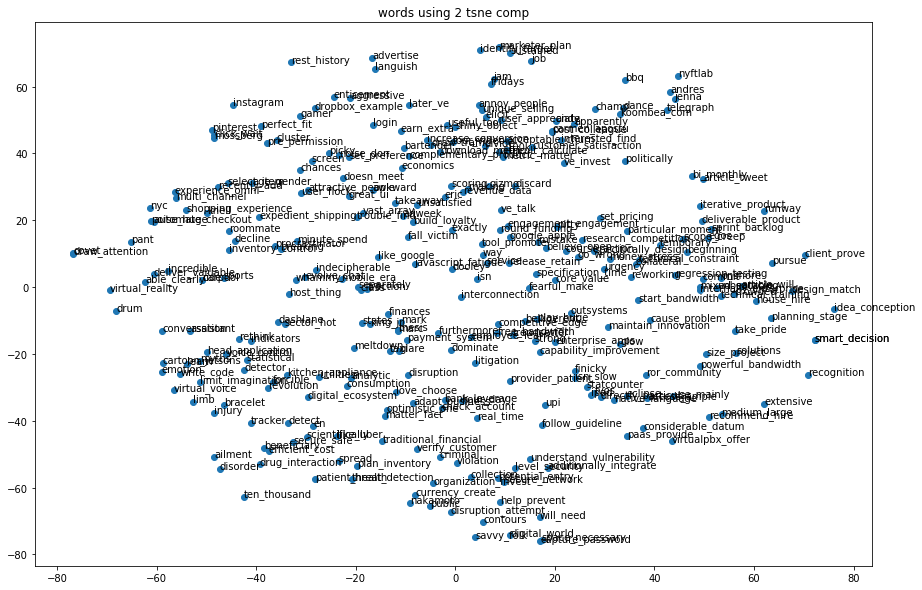

In [57]:
%matplotlib inline
visualize_words_embedding(matrix_, vocab, total=300, width=15, height=10)

# Blogs embedding

In [58]:
from fse.models import SIF, Average
from fse import IndexedList
import pickle

In [59]:
fse_data = IndexedList(train_data) # Tranform to fse format

In [63]:
fse_model = SIF(sg_model, workers=number_cpus, lang_freq='en', components=0) #own model

2020-06-08 20:21:59,413 : INFO : no frequency mode: using wordfreq for estimation of frequency for language: en


In [64]:
fse_model.train(fse_data)

2020-06-08 20:22:00,891 : INFO : scanning all indexed sentences and their word counts
2020-06-08 20:22:00,893 : INFO : finished scanning 458 sentences with an average length of 400 and 183555 total words
2020-06-08 20:22:00,899 : INFO : estimated memory for 458 sentences with 300 dimensions and 21009 vocabulary: 24 MB (0 GB)
2020-06-08 20:22:00,900 : INFO : initializing sentence vectors for 458 sentences
2020-06-08 20:22:00,905 : INFO : pre-computing SIF weights for 21009 words
2020-06-08 20:22:00,916 : INFO : begin training
2020-06-08 20:22:00,965 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 20:22:00,966 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 20:22:00,967 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 20:22:00,967 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 20:22:00,967 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 20:

(458, 183555)

In [65]:
blog_matrix = fse_model.sv.vectors
blog_matrix.shape

(458, 300)

In [67]:
TFIDF_MATRIX = pickle.load(open("model/tfidf_bigrams.pickle", "rb"))
vocab_ = pickle.load(open("model/vocab_bigrams.pickle", "rb"))

## Visualize blogs embeddings

### Trucated svd to reduce simension down to 50

In [68]:
blog_matrix_truncated = TruncatedSVD(n_components=50).fit_transform(blog_matrix)

### Tsne manifold to reduce dimension down to 2

In [69]:
blog_matrix_tsne = TSNE(n_components=2).fit_transform(blog_matrix_truncated)

### Visualize Blogs

In [70]:
from sklearn.cluster import KMeans

In [71]:
clusters = KMeans(n_clusters=25).fit_predict(blog_matrix_tsne)

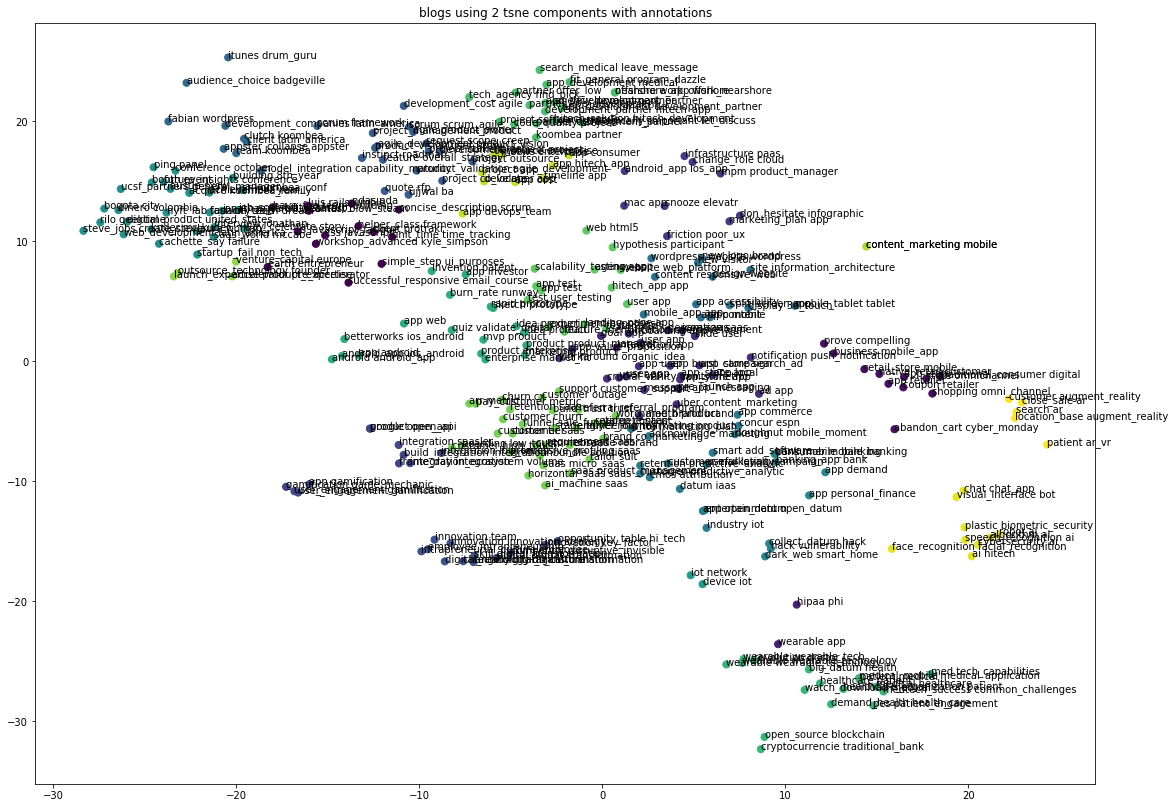

In [74]:
%matplotlib inline
plots_blogs_embedding(TFIDF_MATRIX, blog_matrix_tsne, vocab_, clusters, width=19, height=14)

We can see some cluster for example blogs with ai, and machine learning topic are together, blogs about vr, ar are together, blogs about gamification too

# Similarity Query

In [75]:
from gensim.summarization import summarize

## Pick a blog and summarize using gensim

In [76]:
print(blogs_df.title[455].upper())
print(summarize(blogs_df.normalize_data[455]))

2020-06-08 20:23:23,055 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 20:23:23,057 : INFO : built Dictionary(329 unique tokens: ['bad', 'covid', 'depress', 'econom', 'enter']...) from 82 documents (total 573 corpus positions)
2020-06-08 20:23:23,059 : INFO : Building graph
2020-06-08 20:23:23,060 : INFO : Filling graph
2020-06-08 20:23:23,068 : INFO : Removing unreachable nodes of graph
2020-06-08 20:23:23,069 : INFO : Pagerank graph
2020-06-08 20:23:23,075 : INFO : Sorting pagerank scores


FINTECH TRENDS 2020: THE GOOD, THE BAD, AND THE UGLY
FinTech Trends 2020: The Good, the Bad, and the Ugly Due to the Covid-19 pandemic, the world is entering an economic turmoil not seen since the Great Depression.
Governments all over the world are implementing generous aid programs to help companies and people, but uncertainty prevails.
FinTech, a sector that was performing great before Covid-19, is at the crossroads between surviving the crisis and a universe of opportunities.
In this post we analyze some of the most important FinTech trends that investors and managers should keep on their radar if they wish to stay afloat and come out of the crisis stronger.
Although some FinTech companies are struggling due to the economy’s overall impact, it is safe to say that the majority continue to operate at levels of performance equal to or above before the pandemic.
Some FinTech real estate and insurance companies seem to be having a hard time, although this seems more of a temporary issue

the blogs is about Fintech trends in 2020 and the impact dur to the covid-19 over fintech world, let's search for some similar blogs

In [77]:
values = fse_model.sv.most_similar(455, topn=3)
values_ = [val[0] for val in values]
values

2020-06-08 20:23:26,911 : INFO : precomputing L2-norms of sentence vectors


[(408, 0.9386863708496094),
 (419, 0.9385214447975159),
 (430, 0.9286941289901733)]

In [78]:
print(blogs_df.title[values_[0]].upper())
print(summarize(blogs_df.normalize_data[values_[0]]))
print("\n")
print(blogs_df.title[values_[1]].upper())
print(summarize(blogs_df.normalize_data[values_[1]]))
print("\n")
print(blogs_df.title[values_[2]].upper())
print(summarize(blogs_df.normalize_data[values_[2]]))

2020-06-08 20:23:31,633 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 20:23:31,635 : INFO : built Dictionary(315 unique tokens: ['billion', 'compani', 'despit', 'econom', 'fintech']...) from 60 documents (total 554 corpus positions)
2020-06-08 20:23:31,636 : INFO : Building graph
2020-06-08 20:23:31,636 : INFO : Filling graph
2020-06-08 20:23:31,643 : INFO : Removing unreachable nodes of graph
2020-06-08 20:23:31,644 : INFO : Pagerank graph
2020-06-08 20:23:31,648 : INFO : Sorting pagerank scores
2020-06-08 20:23:31,656 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 20:23:31,657 : INFO : built Dictionary(301 unique tokens: ['big', 'financ', 'fintech', 'histor', 'industri']...) from 72 documents (total 534 corpus positions)
2020-06-08 20:23:31,658 : INFO : Building graph
2020-06-08 20:23:31,658 : INFO : Filling graph
2020-06-08 20:23:31,665 : INFO : Removing unreachable nodes of graph
2020-06-08 20:23:31,666 : INFO : Pagerank graph


TOP FINTECH COMPANIES TO WATCH IN 2020
For this reason, we would like to share with you examples of some of the companies that we consider are topping the charts through their innovative business models, user-centered experience, and well-crafted apps.
It seeks to help its users by introducing responsible money management principles; it offers valuable educational content related to investing, retirement, and saving, to mention a few.
As part of its business strategy, Acorns has partnered with some important brands in order to help its users manage their finances.
Its partnership with PayPal has helped the company increase its users while consolidating itself as a major player in the new FinTech environment.
In a world where finance is usually associated with predatory practices, Acorns stands out as what the new integral FinTech company can look like when users’ wellbeing is a priority.
Opendoor has been part of this trend by developing a platform that helps its users simplify the pro